In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.optim as optim
import torch.nn as nn
from model import *
from tqdm import tqdm


# data preprocessing import
from __future__ import print_function
import IPython
import sys
from music21 import *
import numpy as np
from grammar import *
from qa import *
from preprocess import * 
from music_utils import *
from data_utils import *

Using TensorFlow backend.


In [2]:
import os
def mkdir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
mkdir("models/")
experiment_id = "GAN"

In [3]:
X, Y, n_values, indices_values = load_music_utils()
print('shape of X:', X.shape)
print('number of training examples:', X.shape[0])
print('Tx (length of sequence):', X.shape[1])
print('total # of unique values:', n_values)
print('Shape of Y:', Y.shape)

shape of X: (60, 100, 78)
number of training examples: 60
Tx (length of sequence): 100
total # of unique values: 78
Shape of Y: (100, 60, 78)


In [4]:
# Convert X into (Tx, n_sample, n_feature)
X = np.transpose(X,(1,0,2))
print("(Tx, n_sample, n_feature):", X.shape)

(Tx, n_sample, n_feature): (100, 60, 78)


In [5]:
# Setup parameters
n_sequence = X.shape[0]
n_step = X.shape[1]
n_input = n_output = X.shape[2]
n_hidden = 128
n_epoch = 150

In [6]:
# Setup model, optimizer
net = Model(n_input, n_hidden, n_output)
disc = FFDiscriminator(n_sequence*n_output, n_hidden , 1) # Real of Fake
optimizer = optim.Adam(net.parameters(), lr=0.01)
disc_optimizer = optim.Adam(disc.parameters(), lr=0.01)

net.cuda()
disc.cuda()

FFDiscriminator(
  (main): Sequential(
    (0): Linear(in_features=7800, out_features=128, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [7]:
# print("Test model inference")

# dummy_x = torch.randn([n_sequence,1,n_input]).cuda()
# print("Input Size:",dummy_x.size())

# dummy_pred,_ = net(dummy_x)
# print("Output size:", dummy_pred.size())

# dummy_label = (torch.randn(dummy_pred.size())>0.5).argmax(dim=1)
# print("Label size:",dummy_label)

# dummy_loss = F.cross_entropy(dummy_pred, dummy_label)
# print("Loss", dummy_loss.data.numpy())

In [8]:
print("Training")
X = X.astype("float32")
Y = Y.astype(int)

losses = []
for epoch in range(n_epoch):
    total_loss = 0
    for step in range(n_step):
        x = torch.tensor(X[:,step,:]).unsqueeze(1)  # (30,1,78)
        y = torch.tensor(Y[:,step,:], dtype=torch.long).argmax(dim=1) # (30,1)
        y_seq = torch.tensor(Y[:,step,:],dtype=torch.float) # (30,1,78)
        
        x = x.cuda()
        y = y.cuda()
        y_seq = y_seq.cuda()
        # Initialize hidden state
        net.hidden = net.init_hidden(use_cuda=True)

        # Feed the data
        prob_y, _ = net(x)                             # (30,78)
        
        # Discriminator's Step
        # ===========================================================================================
        # Feed the prob_y to the FFDiscriminator
        fake_prob = disc(prob_y.view(-1).cuda())
        loss_gan_fake = F.binary_cross_entropy_with_logits(fake_prob, torch.zeros_like(fake_prob).cuda())
        
        real_prob = disc(y_seq.view(-1).cuda())
        loss_gan_real = F.binary_cross_entropy_with_logits(real_prob, torch.ones_like(real_prob).cuda())
        disc_loss = loss_gan_real + loss_gan_fake
        
        disc_optimizer.zero_grad()
        disc_loss.backward()
        disc_optimizer.step()
        
        # Generator's Step
        # ===========================================================================================
        net.hidden = net.init_hidden(use_cuda=True)
        prob_y, _ = net(x)
        fake_prob = disc(prob_y.view(-1).cuda())
        gan_loss = F.binary_cross_entropy_with_logits(fake_prob, torch.ones_like(fake_prob).cuda())
        chord_loss = F.cross_entropy(prob_y, y)
        
        loss = chord_loss + gan_loss
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.cpu().data.numpy()
#         print(list(y.data.numpy().squeeze()))
        
    losses.append(total_loss)
    print("Epoch {}, Loss {}".format(epoch, total_loss))
    save_path = "models/{}_{}_deepjazz.pth".format(experiment_id, epoch)
    print("Saving the model to", save_path)
    torch.save(net.state_dict(), save_path)





Training
Epoch 0, Loss 715.5747337341309
Saving the model to models/GAN_0_deepjazz.pth
Epoch 1, Loss 1785.5273280143738
Saving the model to models/GAN_1_deepjazz.pth
Epoch 2, Loss 2393.1868720054626
Saving the model to models/GAN_2_deepjazz.pth
Epoch 3, Loss 1603.4001197814941
Saving the model to models/GAN_3_deepjazz.pth
Epoch 4, Loss 684.1167373657227
Saving the model to models/GAN_4_deepjazz.pth
Epoch 5, Loss 576.2429103851318
Saving the model to models/GAN_5_deepjazz.pth
Epoch 6, Loss 562.674334526062
Saving the model to models/GAN_6_deepjazz.pth
Epoch 7, Loss 604.6301383972168
Saving the model to models/GAN_7_deepjazz.pth
Epoch 8, Loss 599.9206228256226
Saving the model to models/GAN_8_deepjazz.pth
Epoch 9, Loss 565.1851501464844
Saving the model to models/GAN_9_deepjazz.pth
Epoch 10, Loss 610.5361547470093
Saving the model to models/GAN_10_deepjazz.pth
Epoch 11, Loss 600.2499160766602
Saving the model to models/GAN_11_deepjazz.pth
Epoch 12, Loss 601.536506652832
Saving the model 

Saving the model to models/GAN_102_deepjazz.pth
Epoch 103, Loss 845.5573635101318
Saving the model to models/GAN_103_deepjazz.pth
Epoch 104, Loss 831.5645980834961
Saving the model to models/GAN_104_deepjazz.pth
Epoch 105, Loss 832.6157693862915
Saving the model to models/GAN_105_deepjazz.pth
Epoch 106, Loss 894.4226312637329
Saving the model to models/GAN_106_deepjazz.pth
Epoch 107, Loss 761.6975440979004
Saving the model to models/GAN_107_deepjazz.pth
Epoch 108, Loss 809.2255754470825
Saving the model to models/GAN_108_deepjazz.pth
Epoch 109, Loss 809.7551517486572
Saving the model to models/GAN_109_deepjazz.pth
Epoch 110, Loss 895.6041879653931
Saving the model to models/GAN_110_deepjazz.pth
Epoch 111, Loss 818.7526054382324
Saving the model to models/GAN_111_deepjazz.pth
Epoch 112, Loss 812.4434118270874
Saving the model to models/GAN_112_deepjazz.pth
Epoch 113, Loss 839.8631315231323
Saving the model to models/GAN_113_deepjazz.pth
Epoch 114, Loss 1015.0926151275635
Saving the mode

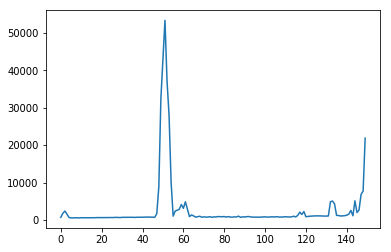

In [9]:
plt.plot(losses)
plt.show()
